In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
from datetime import datetime, timedelta

# Load your data
data = pd.read_csv('SA_Weather_Obs.csv')
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

# Extract date features
data['Day'] = data['date'].dt.day
data['Month'] = data['date'].dt.month
data['Year'] = data['date'].dt.year
data['DayOfWeek'] = data['date'].dt.dayofweek

# Create lag features for rainfall
data['rain_lag_1'] = data['rain'].shift(1)
data['rain_lag_2'] = data['rain'].shift(2)

# Create rolling mean feature for rainfall
data['rain_rolling_mean_3'] = data['rain'].rolling(window=3).mean()

# Encode 'station_name'
le_station = LabelEncoder()
data['station_name_encoded'] = le_station.fit_transform(data['station_name'])

# Define features used for imputation models
impute_features = ['ev_transpiration', 'max_temp', 'min_temp', 'max_humid', 'min_humid', 'wind', 'solar']

# Initialize a dictionary to store imputation models
impute_models = {}

# Train separate Random Forest model for each feature to be imputed
for feature in impute_features:
    impute_data = data.dropna(subset=[feature])
    X_impute = impute_data[['station_name_encoded', 'Day', 'Month', 'Year', 'DayOfWeek']]
    y_impute = impute_data[feature]
    
    X_train_impute, X_val_impute, y_train_impute, y_val_impute = train_test_split(
        X_impute, y_impute, test_size=0.3, random_state=42
    )
    
    impute_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    impute_model.fit(X_train_impute, y_train_impute)
    
    y_pred_impute = impute_model.predict(X_val_impute)
    impute_mae = mean_absolute_error(y_val_impute, y_pred_impute)
    impute_rmse = np.sqrt(mean_squared_error(y_val_impute, y_pred_impute))
    impute_r2 = r2_score(y_val_impute, y_pred_impute)
    
    print(f"Imputation Model for {feature}: MAE: {impute_mae:.4f}, RMSE: {impute_rmse:.4f}, R2: {impute_r2:.4f}\n")
    impute_models[feature] = impute_model

# Create a binary target variable 'rain_binary': 1 if rain > 0, else 0
data['rain_binary'] = np.where(data['rain'] > 0, 1, 0)

# Define features used for classification
feature_cols = [
    'station_name_encoded',
    'ev_transpiration',
    'max_temp',
    'min_temp',
    'max_humid',
    'min_humid',
    'wind',
    'solar',
    'Day',
    'Month',
    'Year',
    'DayOfWeek',
    'rain_lag_1',           # Include lag features
    'rain_lag_2',
    'rain_rolling_mean_3'
]

# Filter out rows with missing values in the features
data = data.dropna(subset=feature_cols + ['rain_binary'])

X = data[feature_cols]
y = data['rain_binary']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the RandomForestClassifier with the provided best hyperparameters
rain_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Train the model
rain_classifier.fit(X_train, y_train)

# Perform cross-validation
cv_scores = cross_val_score(rain_classifier, X, y, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores for Rain Classifier:", cv_scores)
print("Mean Cross-Validation Accuracy Score for Rain Classifier:", np.mean(cv_scores))

# Predict on the test set
y_test_pred = rain_classifier.predict(X_test)

# Evaluate on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

print("\nRain Classifier Evaluation Metrics on Test Set:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"AUC Score: {test_auc:.4f}")

# Predict on the training set
y_train_pred = rain_classifier.predict(X_train)

# Evaluate on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, y_train_pred)

print("\nRain Classifier Evaluation Metrics on Train Set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print(f"AUC Score: {train_auc:.4f}")

# Prepare future data for rain probability prediction
# Ensure future_df is defined and populated appropriately
future_dates = pd.date_range(start=data['date'].max() + timedelta(days=1), periods=30)
unique_stations = data['station_name'].unique()
future_data = [{'date': date, 'station_name': station} for date in future_dates for station in unique_stations]
future_df = pd.DataFrame(future_data)

# Encode 'station_name' and extract date features
future_df['station_name_encoded'] = le_station.transform(future_df['station_name'])
future_df['Day'] = future_df['date'].dt.day
future_df['Month'] = future_df['date'].dt.month
future_df['Year'] = future_df['date'].dt.year
future_df['DayOfWeek'] = future_df['date'].dt.dayofweek

# Create lag features for rainfall in future_df
future_df['rain_lag_1'] = np.nan  # Placeholder
future_df['rain_lag_2'] = np.nan  # Placeholder
future_df['rain_rolling_mean_3'] = np.nan  # Placeholder

# Impute missing features using the trained models
for feature in impute_features:
    if feature not in future_df.columns:
        future_df[feature] = impute_models[feature].predict(future_df[['station_name_encoded', 'Day', 'Month', 'Year', 'DayOfWeek']])

# Now, fill the lag features based on the historical data
# Combine historical and future data to fill lag features
combined_df = pd.concat([data, future_df], ignore_index=True)

# Calculate lag features for the combined DataFrame
combined_df['rain_lag_1'] = combined_df['rain'].shift(1)
combined_df['rain_lag_2'] = combined_df['rain'].shift(2)
combined_df['rain_rolling_mean_3'] = combined_df['rain'].rolling(window=3).mean()

# Split combined_df back into historical and future
future_df = combined_df[combined_df['date'].isin(future_dates)]
future_df = future_df[future_df['station_name'].isin(unique_stations)]

# Prepare future data for rain probability prediction
future_X = future_df[feature_cols]

# Predict rain probability
future_df['rain_probability'] = rain_classifier.predict_proba(future_X)[:, 1]

# Select relevant columns to save
output_df = future_df[['date', 'station_name', 'rain_probability']]

# Save to CSV
#output_df.to_csv('rain_probability_predictions.csv', index=False)

print("\nFuture Rain Probability Predictions:")
print(output_df.head(30))


Imputation Model for ev_transpiration: MAE: 1.1620, RMSE: 1.5762, R2: 0.6431

Imputation Model for max_temp: MAE: 3.2427, RMSE: 4.1877, R2: 0.6568

Imputation Model for min_temp: MAE: 2.6248, RMSE: 3.3680, R2: 0.5990

Imputation Model for max_humid: MAE: 8.8989, RMSE: 12.4175, R2: 0.5194

Imputation Model for min_humid: MAE: 11.8336, RMSE: 14.7202, R2: 0.4348

Imputation Model for wind: MAE: 1.3571, RMSE: 1.7331, R2: 0.2594

Imputation Model for solar: MAE: 2.6372, RMSE: 3.5993, R2: 0.7673

Cross-Validation Accuracy Scores for Rain Classifier: [0.73497783 0.89340628 0.88618998 0.87491156 0.68911844]
Mean Cross-Validation Accuracy Score for Rain Classifier: 0.815720819073659

Rain Classifier Evaluation Metrics on Test Set:
Accuracy: 0.9084
Precision: 0.8473
Recall: 0.8969
F1 Score: 0.8714
AUC Score: 0.9057

Rain Classifier Evaluation Metrics on Train Set:
Accuracy: 0.9274
Precision: 0.8726
Recall: 0.9265
F1 Score: 0.8987
AUC Score: 0.9272

Future Rain Probability Predictions:
          

In [4]:
from sklearn.metrics import confusion_matrix

y_test_pred_class = rain_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred_class)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[19020  1779]
 [ 1135  9869]]


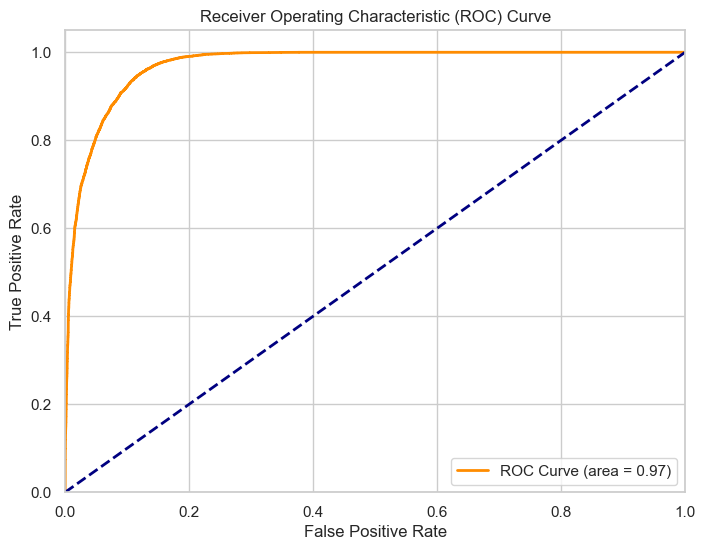

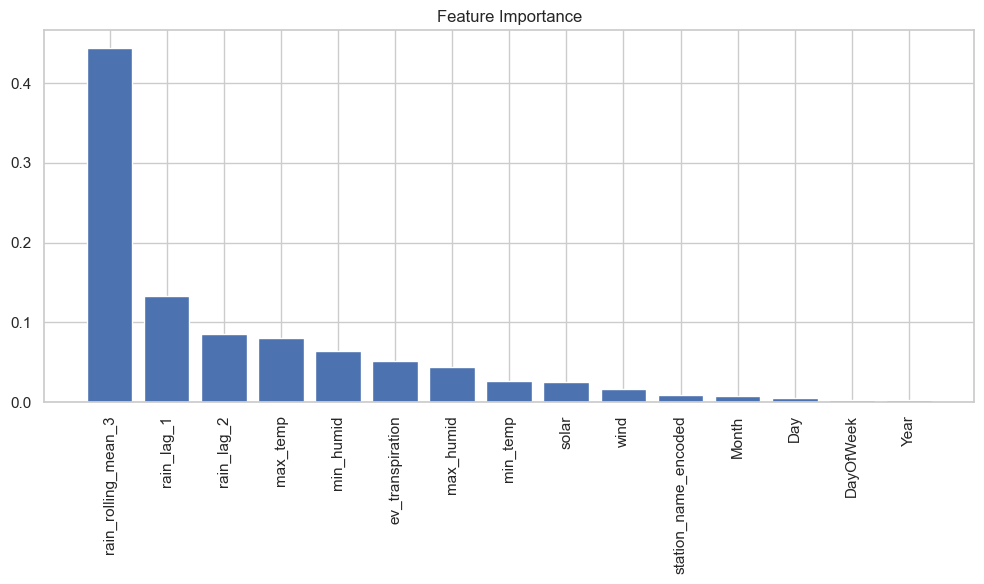

In [18]:
# 2. ROC Curve
def plot_roc_curve(y_true, y_proba):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Plot the ROC curve for the test set
plot_roc_curve(y_test, rain_classifier.predict_proba(X_test)[:, 1])


# 3. Feature Importance Plot
def plot_feature_importance(model, feature_names):
    feature_importance = model.feature_importances_
    indices = np.argsort(feature_importance)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title('Feature Importance')
    plt.bar(range(len(feature_importance)), feature_importance[indices], color='b', align='center')
    plt.xticks(range(len(feature_importance)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

# Plot feature importance
plot_feature_importance(rain_classifier, feature_cols)


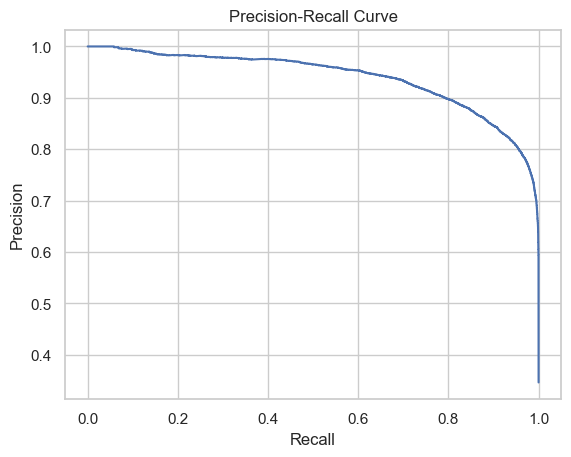

In [6]:
from sklearn.metrics import precision_recall_curve

y_test_pred_proba = rain_classifier.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_proba)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

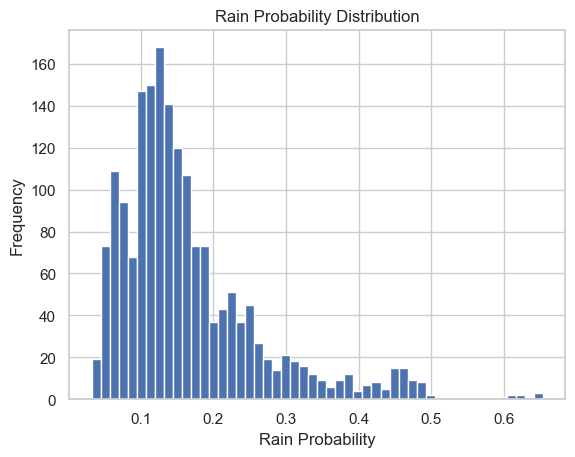

In [7]:
import matplotlib.pyplot as plt

plt.hist(future_df['rain_probability'], bins=50)
plt.xlabel("Rain Probability")
plt.ylabel("Frequency")
plt.title("Rain Probability Distribution")
plt.show()

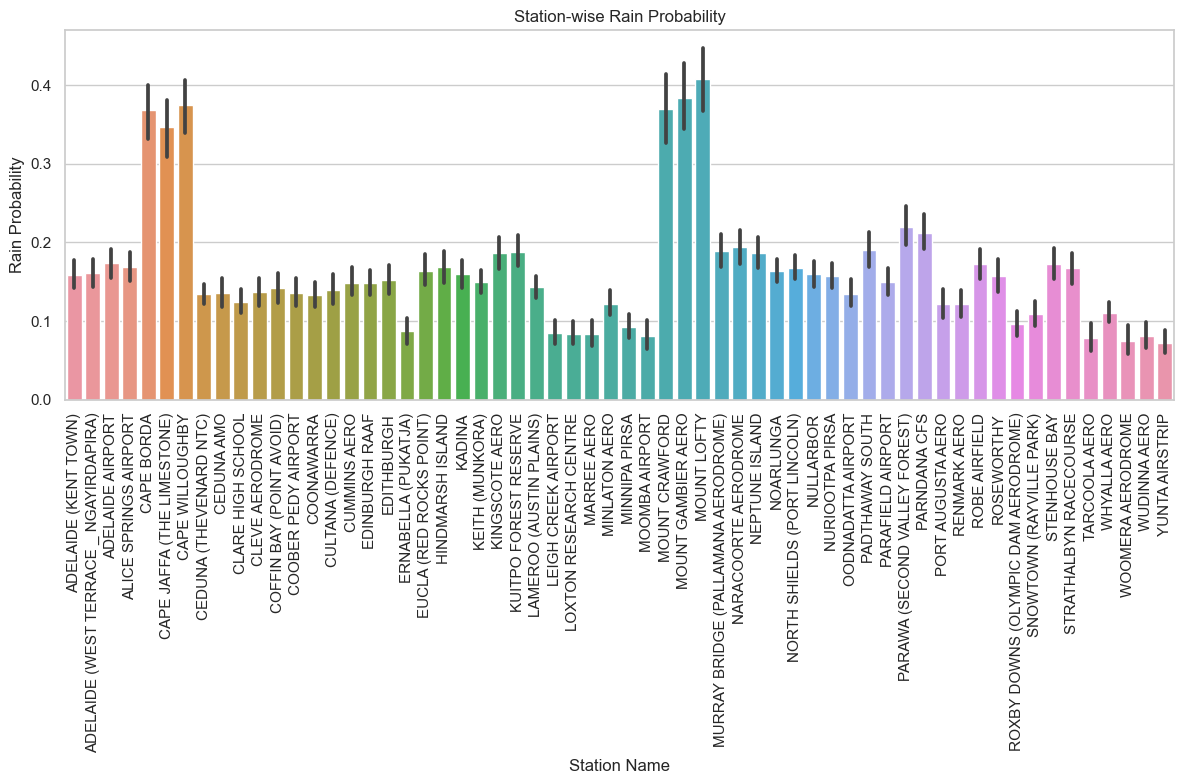

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with a larger size
plt.figure(figsize=(12, 8))

sns.barplot(x="station_name", y="rain_probability", data=future_df)
plt.xlabel("Station Name")
plt.ylabel("Rain Probability")
plt.title("Station-wise Rain Probability")

# Rotate x-axis tick labels by 90 degrees
plt.xticks(rotation=90)

plt.tight_layout()  # Ensure labels fit within the figure area
plt.show()